In [1]:
%matplotlib inline
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
import folium
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
neighbourhoods = geopandas.read_file("Census 2006 - Neighbourhood Boundary.geojson")

In [3]:
neighbourhoods.head()

number                      name  \
0  3.318             Margaret Park   
1  3.324        Templeton-sinclair   
2  3.333  West Kildonan Industrial   
3  4.411            Kildonan Drive   
4  3.323                 Riverbend   

                                            geometry  
0  (POLYGON ((-97.12729918659093 49.9468159651640...  
1  (POLYGON ((-97.12721745582822 49.9468665355230...  
2  (POLYGON ((-97.13595326108339 49.9664629813147...  
3  (POLYGON ((-97.11274918858027 49.9181146475188...  
4  (POLYGON ((-97.10315743821928 49.9518249321091...

In [4]:
print len(neighbourhoods)

230


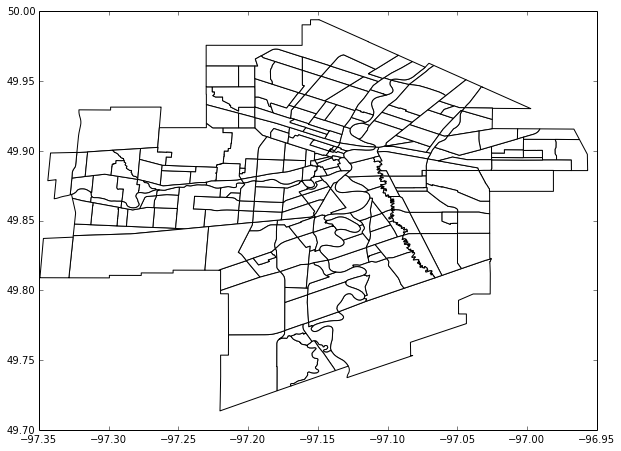

In [5]:
neighbourhoods.plot(figsize=(10, 10), edgecolor='k', facecolor='w')

To work with the tree inventory data which is in a csv file, containing latitude and longitude coordinates. First you have to read into pandas and then do a few operations to convert it to spatial data for geopandas. See [this](https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe) stackexchange post.

In [6]:
tree_data = pd.read_csv("Map_of_Tree_Inventory.csv")
list_of_lat_long_strings = list(tree_data.Location)
list_of_lat_long_tuples_string = [ tuple(x[1:-1].split(', ')) for x in list_of_lat_long_strings]
list_of_lat_long_tuples = [ (float(x[1]), float(x[0])) for x in list_of_lat_long_tuples_string]
geometry = [Point(xy) for xy in list_of_lat_long_tuples]
tree_data = tree_data.drop(['Location'], axis=1)
crs = {'init': 'epsg:4326'}
tree_data = geopandas.GeoDataFrame(tree_data, crs=crs, geometry=geometry)

Here is the tree dataset with the longitude and latitude coordinates converted to geographic data types.

In [7]:
tree_data.head()

Tree ID  Botanical Name   Common Name Electoral Ward Neighbourhood  \
0   178864  Fraxinus nigra     black ash      Transcona       MEADOWS   
1   179254    Acer ginnala    Amur maple      Transcona       MEADOWS   
2     1859    Picea glauca  white spruce   Old Kildonan    THE MAPLES   
3   196032  Fraxinus nigra     black ash   St. Boniface     ROYALWOOD   
4   216297  Fraxinus nigra     black ash    St. Charles      WESTWOOD   

   Diameter at Breast Height                         Park Location Class  \
0                         27                  Not In Park      Boulevard   
1                         21  Kildonan Meadows Park South           Park   
2                         17      Adsum Park / Maples C.C           Park   
3                          7                  Not In Park      Boulevard   
4                         28                  Not In Park      Boulevard   

  Property Type   Street From Street To              X             Y  \
0        Public       Hoka St       End  642436.773247  5.530263e+06   
1        Public           NaN       NaN  641392.146781  5.529950e+06   
2        Public           NaN       NaN  630941.843448  5.535134e+06   
3        Public  Haverhill Cr       End  638052.724301  5.521649e+06   
4        Public     Bedson St       End  621368.879610  5.526182e+06   

                                      geometry  
0   POINT (-97.0162466857297 49.9077680221712)  
1  POINT (-97.03090067762361 49.9052085121029)  
2  POINT (-97.17459612994389 49.9541856042867)  
3    POINT (-97.080340097448 49.8313647693374)  
4   POINT (-97.3107992929162 49.8757286116492)

How many distinct types of trees are there in Winnipeg?

In [8]:
len(set(tree_data['Common Name']))

156

What are the most common types of trees in Winnipeg?

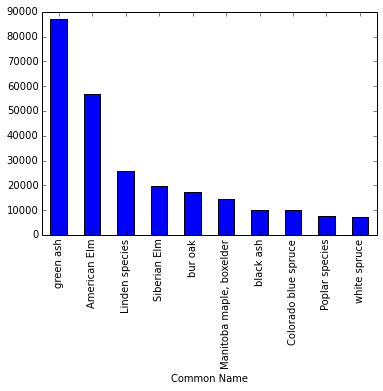

In [9]:
count_common_name = tree_data.groupby('Common Name').size()
common_name_plot = count_common_name.sort_values(ascending = False)[0:10].plot(kind='bar')

fig = common_name_plot.get_figure()
fig.savefig('common_name_plot.png', bbox_inches="tight")
common_name_plot

What are the 50 rarest trees in Winnipeg and where can you find them?

In [10]:
count_common_name.sort_values(ascending = True)[0:10]
tree_data = tree_data.merge(count_common_name.reset_index(name='number_of_tree_type'))
fifty_rarest_trees = tree_data.sort_values(ascending = True, by = 'number_of_tree_type')[0:50]

rare_tree_map = folium.Map(
    location=[49.867902, -97.139187],
    zoom_start=11
)

for idx, row in fifty_rarest_trees.iterrows():
    folium.RegularPolygonMarker(
        [row['geometry'].y, row['geometry'].x],
        color = 'green',
        fill_color='green',
        radius=6,
        popup=row['Common Name'],
    ).add_to(rare_tree_map)

rare_tree_map.save(os.path.join('rare_tree_map.html'))
rare_tree_map

What are the biggest trees in Winnipeg (i.e. diameter) and where can you find them?

In [11]:
tree_data = tree_data.merge(count_common_name.reset_index(name='number_of_tree_type'))
fifty_biggest_trees = tree_data.sort_values(ascending = False, by = 'Diameter at Breast Height')[0:50]

#Scale the diameter value to feed into the radius argument (bigger trees should get bigger icons)
min_diameter = min(fifty_biggest_trees['Diameter at Breast Height'])
max_diameter = max(fifty_biggest_trees['Diameter at Breast Height'])

fifty_biggest_trees['scaled_tree_size'] = (fifty_biggest_trees['Diameter at Breast Height'] 
                                           - min_diameter)/(max_diameter - min_diameter)
#Convert the scale from 0 to 1 to a scale from 4 to 12
fifty_biggest_trees['scaled_tree_size'] = fifty_biggest_trees['scaled_tree_size']*8 + 4

big_tree_map = folium.Map(
    location=[49.867902, -97.139187],
    zoom_start=11
)

for idx, row in fifty_biggest_trees.iterrows():
    folium.RegularPolygonMarker(
        [row['geometry'].y, row['geometry'].x],
        color = 'green',
        fill_color='green',
        radius=row['scaled_tree_size'],
        popup=row['Common Name'],
    ).add_to(big_tree_map)


big_tree_map.save(os.path.join('big_tree_map.html'))
big_tree_map

What neighbourhoods in the city have the most trees?

In [12]:
tree_data = geopandas.sjoin(tree_data, neighbourhoods[['name', 'geometry']].copy(), op='within')
tree_data.head()

Tree ID                              Botanical Name   Common Name  \
222371    35712                                Ulmus pumila  Siberian Elm   
78107     31166  Fraxinus pennsylvanica var. subintegerrima     green ash   
140695    31145                             Ulmus americana  American Elm   
146807    36003                             Ulmus americana  American Elm   
140918    31263                             Ulmus americana  American Elm   

       Electoral Ward  Neighbourhood  Diameter at Breast Height         Park  \
222371       Mynarski  MARGARET PARK                         50  Not In Park   
78107        Mynarski  MARGARET PARK                         27  Not In Park   
140695       Mynarski  MARGARET PARK                         35  Not In Park   
146807       Mynarski  MARGARET PARK                         32  Not In Park   
140918       Mynarski  MARGARET PARK                         50  Not In Park   

       Location Class Property Type  Street From    Street To              X  \
222371      Boulevard        Public  Seaforth Av  Seaforth Av  635553.003266   
78107       Boulevard        Public    Aikins St    Salter St  635447.528913   
140695      Boulevard        Public    Aikins St    Salter St  635346.972551   
146807      Boulevard        Public  Southall Dr  Seaforth Av  635461.708720   
140918      Boulevard        Public    Aikins St    Salter St  635366.554505   

                   Y                                     geometry  \
222371  5.534633e+06   POINT (-97.1105266617039 49.9486504653865)   
78107   5.534632e+06    POINT (-97.1119962974561 49.948667403461)   
140695  5.534631e+06  POINT (-97.11339756304351 49.9486796027079)   
146807  5.534634e+06  POINT (-97.11179814995749 49.9486797504147)   
140918  5.534634e+06  POINT (-97.11312344920211 49.9487088744286)   

        number_of_tree_type  index_right           name  
222371                19630            0  Margaret Park  
78107                 86890            0  Margaret Park  
140695                56660            0  Margaret Park  
146807                56660            0  Margaret Park  
140918                56660            0  Margaret Park

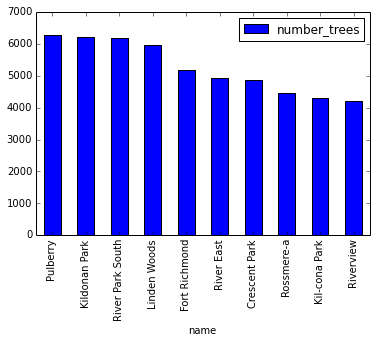

In [13]:
counts = tree_data.groupby('name').size()
neighbourhoods = neighbourhoods.merge(counts.reset_index(name='number_trees'))
most_trees = neighbourhoods[['name', 'number_trees']].sort_values(by=['number_trees'],
                                                                  ascending = False)[0:10].plot(kind='bar',
                                                                                                x = 'name',
                                                                                                y = 'number_trees')
fig = most_trees.get_figure()
fig.savefig('most_trees.png', bbox_inches="tight")
most_trees

In [14]:
number_of_trees_map = folium.Map(location=[49.867902, -97.139187], zoom_start=11)
number_of_trees_map.choropleth(geo_data=neighbourhoods, data=neighbourhoods,
             columns=['number', 'number_trees'],
             key_on = 'feature.properties.number',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Number of Trees',
             reset=True)

number_of_trees_map.save(os.path.join('number_of_trees_map.html'))
number_of_trees_map

What neighbourhoods in the city have the fewest trees?

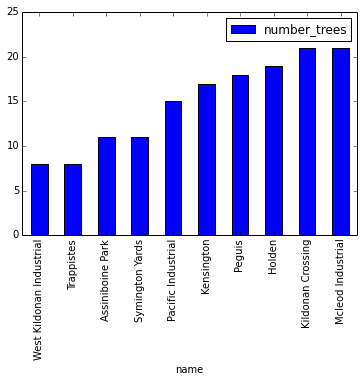

In [15]:
neighbourhood_10_fewest = neighbourhoods[['name', 'number_trees']].sort_values(by=['number_trees'], 
                                                                               ascending = True)[0:10].plot(kind='bar',
                                                                                                            x = 'name',
                                                                                                            y = 'number_trees')
fig = neighbourhood_10_fewest.get_figure()
fig.savefig('neighbourhood_10_fewest.png', bbox_inches="tight")
neighbourhood_10_fewest

What is the density of the trees in Winnipeg neighbourhoods (i.e. trees per square kilometre)?

In [16]:
#Convert projection to cartesian to calculate area in square kilometres
#https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
neighbourhoods_cartesian = neighbourhoods.to_crs({'init': 'epsg:3857'})
neighbourhoods_cartesian["area_sq_km"] = neighbourhoods_cartesian['geometry'].area / 10**6
#Add the area_sq_km to the dataset with the original projection (epsg:4326)
neighbourhoods["area_sq_km"] = neighbourhoods_cartesian["area_sq_km"]
neighbourhoods["trees_per_sq_km"] = neighbourhoods["number_trees"] / neighbourhoods["area_sq_km"]

In [17]:
tree_density_map = folium.Map(location=[49.867902, -97.139187], zoom_start=11)
tree_density_map.choropleth(geo_data=neighbourhoods, data=neighbourhoods,
             columns=['number', 'trees_per_sq_km'],
             key_on = 'feature.properties.number',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Number of trees per square kilometre',
             reset=True)

tree_density_map.save(os.path.join('tree_density_map.html'))
tree_density_map

Neighbourhoods with the top 10 tree densities (i.e. trees per square kilometre)?.

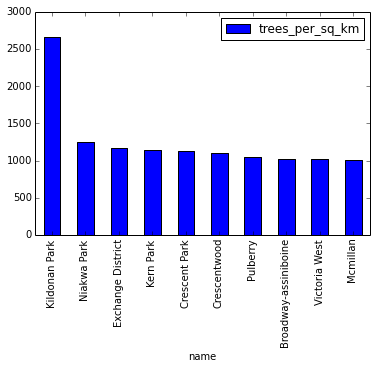

In [18]:
top_10_sq_km = neighbourhoods[['name', 
                               'trees_per_sq_km']].sort_values(by=['trees_per_sq_km'], 
                                                               ascending = False)[0:10].plot(kind='bar',
                                                                                             x = 'name',
                                                                                             y = 'trees_per_sq_km')
fig = top_10_sq_km.get_figure()
fig.savefig('top_10_sq_km.png', bbox_inches="tight")
top_10_sq_km

Neighbourhoods with the bottom 10 tree densities (i.e. trees per square kilometre)?.

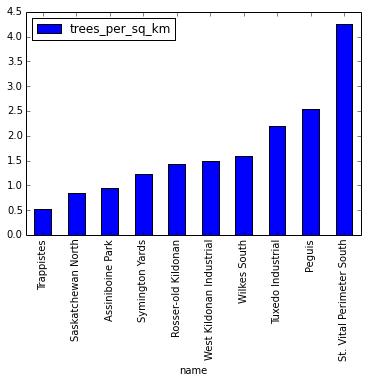

In [19]:
bottom_10_sq_km = neighbourhoods[['name', 'trees_per_sq_km']].sort_values(by=['trees_per_sq_km'],
                                                        ascending = True)[0:10].plot(kind='bar',
                                                                                     x = 'name',
                                                                                     y = 'trees_per_sq_km')
fig = bottom_10_sq_km.get_figure()
fig.savefig('bottom_10_sq_km.png', bbox_inches="tight")
bottom_10_sq_km

### More ideas for analysis:
- Zoom in on one neighbourhood and show a dot map or heat map of all the trees to show the distribution
- What percentage of the trees come from parks?
- Which neighbourhoods have the biggest trees?
- Develop a "tree index" for each neighbourhood
- Examine the most common type of tree in each neighbourhood